In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

In [2]:
def jitter_point(mean,std=0.15):
    return np.random.normal(mean,std)

In [3]:
def calculate_fitness(X,O,Ancestor):
    
    sqdistances = distance.cdist(X,O,metric='sqeuclidean')
    Anc_dist2 = np.broadcast_to(distance.cdist(O,[Ancestor],metric='sqeuclidean').T,(X.shape[0],O.shape[0]))
    est_fitness = np.exp((Anc_dist2 - sqdistances) / 2.0) - 1.0

    return est_fitness

In [4]:
def loglikelihood_function(est_fitness,fitness,error,metric='euclidean'):    
        
    log2pi_variance = np.log(np.sqrt(2.0 * np.pi * error))
    inverse_variance = 1.0/error
    log_likelihood = -log2pi_variance - 0.5 * inverse_variance * np.square(fitness - est_fitness)

    return log_likelihood.sum()

def bic(ll,n,k):

    return np.log(n)*k - 2 * ll

def bic1(data,fit,rank):
    
    k = float(rank)
    m = float(data.shape[0])
    n = float(data.shape[1])

    return np.log(np.linalg.norm(data-fit)**2)  + k*(m+n)/(m*n)*np.log(m*n/(m+n))

def bic2(data,fit,rank):
    
    k = float(rank)
    m = float(data.shape[0])
    n = float(data.shape[1])
    C = np.min([np.sqrt(m),np.sqrt(n)])

    return np.log(np.linalg.norm(data-fit)**2)  + k*(m+n)/(m*n)*np.log(C**2)

def bic3(data,fit,rank):
    
    k = float(rank)
    m = float(data.shape[0])
    n = float(data.shape[1])
    C = np.min([np.sqrt(m),np.sqrt(n)])

    return np.log(np.linalg.norm(data-fit)**2)  + k*np.log(C**2)/C**2

def aic(ll,k):

    return 2*k - 2 * ll

def var_explained(data,model):
    
    ss_res = np.sum((data-model)**2)
    ss_tot = np.sum((data-np.mean(data))**2)
    
    return 1 - ss_res/ss_tot, ss_res, ss_tot

In [5]:
def SVD_predictions(data,truth,folds,n_mutants,n_conditions,n_folds,permuted_mutants=False,permuted_conditions=False,mse=False):
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    all_folds = np.zeros(max_rank)
    true_folds = np.zeros(max_rank)
    for new_m,new_c in folds:
        old_m = sorted([i for i in range(n_mutants) if i not in new_m])
        old_c = sorted([i for i in range(n_conditions) if i not in new_c])
        rank_fit = []
        true_fit = []
        
        if permuted_mutants and permuted_conditions:
            this_data = copy.copy(data)
            this_data[old_m,old_c] = np.random.permutation(this_data[old_m,old_c].ravel()).reshape(len(old_m),len(old_c))
            subset = this_data[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].ravel()
            
        elif permuted_mutants:
            this_data = copy.copy(data)
            for mut in old_m:
                this_data[mut,old_c] = np.random.permutation(this_data[mut,old_c])
        
        elif permuted_conditions:
            
            this_data = np.swapaxes(copy.copy(data))
            for cond in old_c:
                this_data[cond,old_m] = np.random.permutation(this_data[cond,old_m])
            this_data = np.swapaxes(this_data,0,1)
              
        else:
            this_data = copy.copy(data)
            
            
        
        both_old = this_data[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))

        
        U2, s2, V2 = np.linalg.svd(both_old)
        mut_new = this_data[np.repeat(new_m,len(old_c)),np.tile(old_c,len(new_m))].reshape(len(new_m),len(old_c))                    
        cond_new = this_data[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))
        both_new = this_data[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))
        both_true = truth[np.repeat(new_m,len(new_c)),np.tile(new_c,len(new_m))].reshape(len(new_m),len(new_c))
        
        for rank in range(1,max_rank+1):
     
            new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
            S2 = np.zeros((U2.shape[0],V2.shape[0]))
            S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)

            D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
            A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))
            if mse:
                rank_fit.append(np.sum(np.square(both_new-A_hat)))
                true_fit.append(np.sum(np.square(both_true-A_hat)))
            else:
                rank_fit.append(var_explained(both_new,A_hat)[0])
                true_fit.append(var_explained(both_true,A_hat)[0])
        all_folds = all_folds + rank_fit
        true_folds = true_folds + true_fit
        
    return all_folds, true_folds

In [6]:
def SVD_fits(data,mse=False):
    U, s, V = np.linalg.svd(data)
    fits = []
    model_vars = []
    bic_1 = []
    bic_2 = []
    bic_3 = []

    for rank in range(1,data.shape[1]+1):
#             print(err,rep,rank)
        this_s = np.asarray(list(s[:rank]) + list(np.zeros(s[rank:].shape)))
        S = np.diag(this_s)
        this_rank = np.dot(U[:,:rank],np.dot(S,V)[:rank,:])
        if mse:
            fits.append(np.sum(np.square(data-this_rank)))
            model_vars.append(np.sum(np.square(data-this_rank)))
        else:
            var_explain, model_var, total_var = var_explained(data,this_rank)
            fits.append(var_explain)
            model_vars.append(model_var)
        bic_1.append(bic1(data,this_rank,rank))
        bic_2.append(bic2(data,this_rank,rank))
        bic_3.append(bic3(data,this_rank,rank))
      
    return fits, model_vars, bic_1, bic_2, bic_3

In [9]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [i*1e-4 for  i in range(10)]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[1]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

# f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
# f = f[[col for col in f.columns if 'fitness' in col]]
# f = f.values

fitness, sim_id, n_dim, n_mut, n_con = simulation(10,50,250,optimum_deviation=0.5)
f = fitness

d_est = []
for cv in range(n_cvs):
    fit_fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        plt.subplot(2,5,counter)
#         prd_ax = prd_fig.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = this_set - np.mean(this_set)
        f = f - np.mean(f)
        true_var_explained, y,x = var_explained(this_set,f)
#         real_fits = SVD_predictions(this_set,folds,n_mutants,n_conditions,n_folds)
#         these_fits = real_fits/n_folds
        
        noprediction,modelfits,bic_1,bic_2,bic_3 = SVD_fits(this_set)
        
#         if err == err_list[0]:
#             print(([noprediction[0]]+list((np.asarray(noprediction[1:]+[1.0])-noprediction)))[:d_true])
#         print(err,(np.var(this_set)-np.var(f))/np.var(this_set))
        
        plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)

        plt.axhline(y=true_var_explained,color='b',linestyle=':')
        plt.axvline(x=d_true,color='k',linestyle=':')
        

    
    fit_fig.tight_layout()
#     fit_fig.savefig('SVDAnalysis/d{}_fits_error_range.pdf'.format(d_true),bbox_inches='tight')
    
#     prediction_fig.tight_layout()
#     prediction_fig.savefig('SVDAnalysis/d{}_error_range.pdf'.format(d_true),bbox_inches='tight')



NameError: name 'these_sims' is not defined

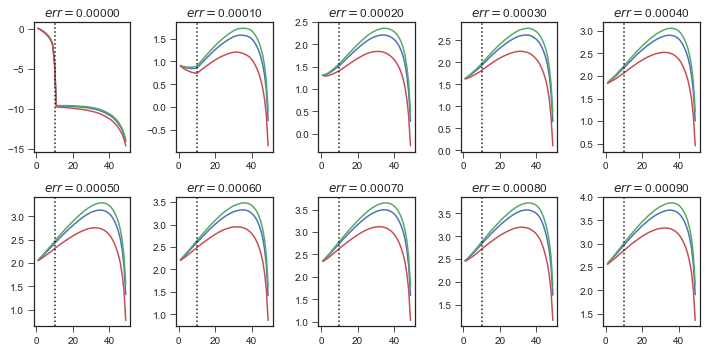

In [60]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [i*1e-4 for  i in range(10)]
sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
n_folds = 5
n_cvs = 1
n_permutations = 10

sigma = sigmas[2]
color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
sim_id = sigma_sims['simulation_identifier'].values[0]
d_true = sigma_sims['n_dimensions'].values[0]

f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
f = f[[col for col in f.columns if 'fitness' in col]]
f = f.values

d_est = []
for cv in range(n_cvs):
    fit_fig = plt.figure(figsize=(10,5))
#     prd_fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        plt.subplot(2,5,counter)
#         prd_ax = prd_fig.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
#         real_fits = SVD_predictions(this_set,folds,n_mutants,n_conditions,n_folds)
#         these_fits = real_fits/n_folds
        
        noprediction,bic_1,bic_2,bic_3 = SVD_fits(this_set)
        
#         fit_ax.plot(range(1,max_rank+1),these_fits,color='k',label=d_list[item],alpha=1.0)
#         fit_ax.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='k',alpha=1.0)

#         plt.plot(range(1,f.shape[1]+1),noprediction,color='k',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_1[:-1],color='b',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_2[:-1],color='g',label=d_true,alpha=1.0)
        plt.plot(range(1,f.shape[1]),bic_3[:-1],color='r',label=d_true,alpha=1.0)
        plt.axvline(x=d_true,color='k',linestyle=':')
        
#         for perm in range(n_permutations):
#             permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
#             perm_fits = SVD_predictions(permuted_mutants,folds,n_mutants,n_conditions,n_folds)
#             these_fits = perm_fits/n_folds
            
# #             noprediction = SVD_fits(permuted_mutants)
            
#             plt.plot(range(1,max_rank+1),these_fits,color='gray',label=d_list[item],alpha=0.5,linestyle='--')
#             plt.scatter(range(1,max_rank+1)[np.where(these_fits==np.max(these_fits))[0][0]],np.max(these_fits),color='gray',alpha=0.5,linestyle='--')
            
# #             plt.plot(range(1,f.shape[1]+1),noprediction,color='gray',label=d_list[item],alpha=0.5)
    
    fit_fig.tight_layout()
    fit_fig.savefig('SVDAnalysis/d{}_BICs_error_range.pdf'.format(d_true),bbox_inches='tight')
    
#     prediction_fig.tight_layout()
#     prediction_fig.savefig('SVDAnalysis/d{}_error_range.pdf'.format(d_true),bbox_inches='tight')


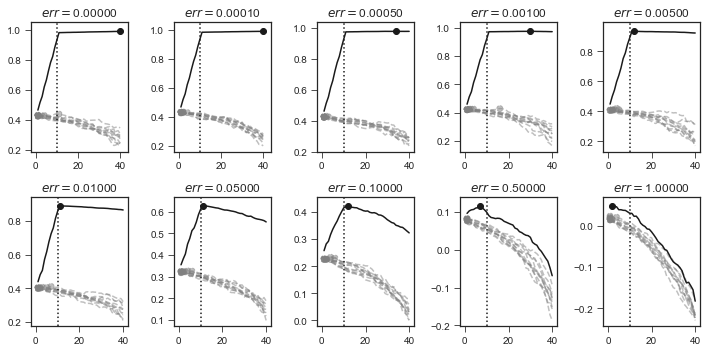

In [18]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [0]+[i*0.5e-4 for  i in range(2,11)]
err_list = [0]+[i*1e-3 for  i in range(2,11)]
err_list = [0]+[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1.0]

n_folds = 5
n_cvs = 1
n_permutations = 10


color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}

# sigmas = np.unique(these_sims[these_sims['batch_name']=='fgm_simulation_set1_default']['Sigma2'].values)
# sigma = sigmas[1]
# sigma_sims = these_sims[(these_sims['batch_name']=='fgm_simulation_set1_default') & (these_sims['Sigma2']==sigma)]
# sim_id = sigma_sims['simulation_identifier'].values[0]
# d_true = sigma_sims['n_dimensions'].values[0]
# f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
# f = f[[col for col in f.columns if 'fitness' in col]]
# f = f.values

d_true = 10
optimum_deviation = 1.0



fitness, sim_id, n_dim, n_mut, n_con = simulation(d_true,250,50,optimum_deviation=optimum_deviation,dry_run=False)
f = fitness

d_est = []
d_list = []
for cv in range(n_cvs):
    fig = plt.figure(figsize=(10,5))
    counter = 1
    
    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        ax = plt.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.5f}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained = var_explained(this_set,f)[0]
        
        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        real_fits = real_fits/n_folds
#         true_fits = true_fits/n_folds
        
        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])
            
            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
            perm_fits = perm_fits/n_folds
            
            
            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
#         true_fits = true_fits-(true_fits[0]-these_fits[0])
        
        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)
        
#         plt.plot(range(1,max_rank+1),true_fits,color='r',label=d_true,alpha=1.0)
#         plt.scatter(range(1,max_rank+1)[np.where(true_fits==np.max(true_fits))[0][0]],np.max(true_fits),color='r',alpha=1.0)

#         plt.xlabel('D estimated')
#         plt.ylabel('Variance Explained in Test Set')
        plt.axvline(x=d_true,color='k',linestyle=':')
#         plt.axhline(y=true_var_explained,color='b',linestyle=':')

        
#         true_var_explained.append(real_fits/n_folds)
        

#     ax.
    fig.tight_layout()
    plt.savefig('SVDAnalysis/d{}_{}_{}_permTrain_error_range.pdf'.format(d_true,optimum_deviation,sim_id),bbox_inches='tight')



In [19]:
np.var(np.mean(f,axis=0))
# sns.distplot(np.mean(f,axis=0))

0.058427625104241265

a8d9f6d9ba924dd7a67a9627e81748a3


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


TypeError: only integer scalar arrays can be converted to a scalar index

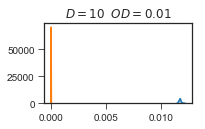

In [184]:
sim_ids = ['a8d9f6d9ba924dd7a67a9627e81748a3', # od = 0.01, max err < 0.0001
'5f83966a1903468a935ecadcb3e1fe86', # od = 0.1, max err: 0.001 - 0.005           
'c9af5bc1018e4cde85039da2ee6ea27d',# od = 0.2, max err: 0.01 - 0.05
'866fe66da1cd48768a984d2c9711b563', # od = 0.25, max err: 0.01 - 0.05
'9098bcac47514def897b9fab9829b7f7', # od = 0.5, max err: 0.05 - 0.1
'3d1639a25cda4320b128ea519986f38b'  # od = 1.0, max err: 0.5 - 1.0     
          ] 
avg_mutant_var = []
avg_condition_var = []
condition_cv = []
mutant_cv = []
fig = plt.figure(figsize=(9,5))
counter = 1
for sim_id in sim_ids:
    f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
    f = f[[col for col in f.columns if 'fitness' in col]]
    f = f.values
    
    print(sim_id)
#     print(np.var(f))
#     print(np.mean(f))
    plt.subplot(3,3,counter)
    plt.title(r'$D = 10$  $OD = {}$'.format(optimum_deviation_dict[sim_id]))
    sns.distplot(np.nanvar(f,axis=0),label='Mutant Variance')
    sns.distplot(np.nanvar(f,axis=1),label='Condition Variance')
    counter +=1 

    avg_mutant_var.append((np.mean(np.nanvar(f,axis=0)/np.nanmean(f,axis=0))))
    avg_condition_var.append((np.mean(np.nanvar(f,axis=1/np.nanmean(f,axis=1)))))
    condition_cv.append((np.var(np.mean(f,axis=0))))
    mutant_cv.append((np.var(np.mean(f,axis=1))))
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
fig.legend(['Mutant Variance','Condition Variance'])
plt.savefig('SVDAnalysis/ACV_AMV_distribution.pdf'.format(sim_id),bbox_inches='tight')
    

Text(0.5,0,'Avg. Variance in Fitness Across Conditions ($ACV$)')

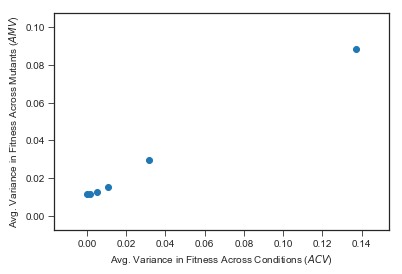

In [86]:
# plt.figure()
# plt.plot(avg_mutant_var)
# plt.figure()
# plt.plot(avg_condition_var)
# plt.figure()
# plt.plot(condition_cv)
# plt.figure()
# plt.plot(mutant_cv)
plt.figure()
plt.scatter(avg_condition_var,avg_mutant_var)
plt.ylabel(r'Avg. Variance in Fitness Across Mutants ($AMV$)')
plt.xlabel(r'Avg. Variance in Fitness Across Conditions ($ACV$)')
# plt.savefig('SVDAnalysis/CVc_ACV_comparison.pdf',bbox_inches='tight')

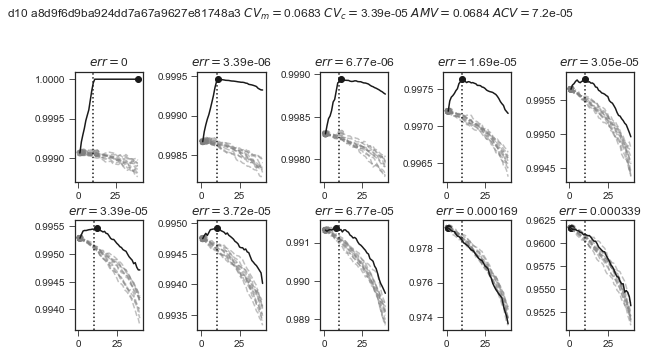

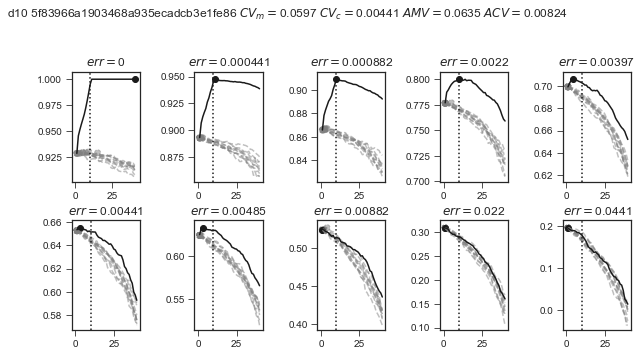

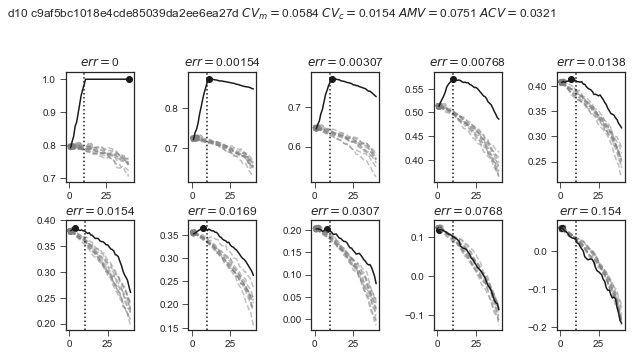

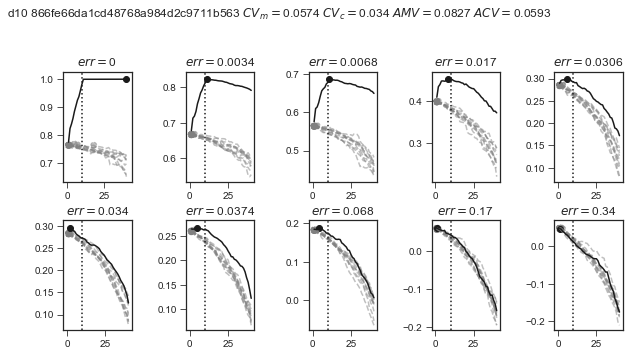

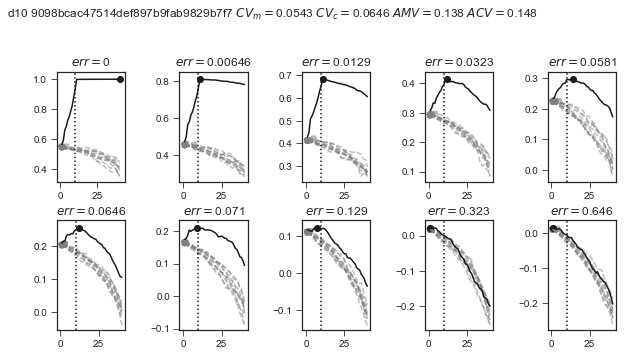

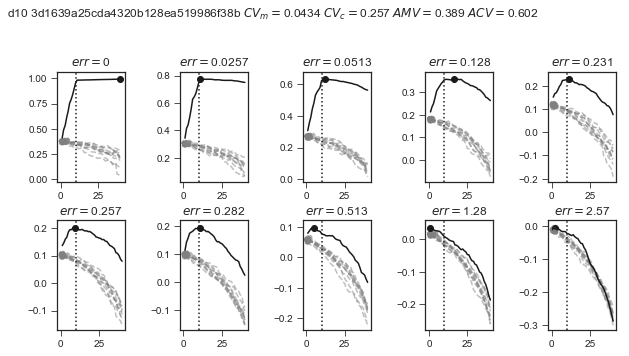

In [10]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [0]+[i*0.5e-4 for  i in range(2,11)]
err_list = [0]+[i*1e-3 for  i in range(2,11)]
err_list = [0]+[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1.0]

n_folds = 5
n_cvs = 1
n_permutations = 10
d_true = 10


color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sim_ids = ['a8d9f6d9ba924dd7a67a9627e81748a3', # od = 0.01, max err < 0.0001
'5f83966a1903468a935ecadcb3e1fe86', # od = 0.1, max err: 0.001 - 0.005           
'c9af5bc1018e4cde85039da2ee6ea27d',# od = 0.2, max err: 0.01 - 0.05
'866fe66da1cd48768a984d2c9711b563', # od = 0.25, max err: 0.01 - 0.05
'9098bcac47514def897b9fab9829b7f7', # od = 0.5, max err: 0.05 - 0.1
'3d1639a25cda4320b128ea519986f38b'  # od = 1.0, max err: 0.5 - 1.0     
          ] 

optimum_deviation_dict = {'a8d9f6d9ba924dd7a67a9627e81748a3':0.01, # od = 0.01, max err < 0.0001
'5f83966a1903468a935ecadcb3e1fe86':0.1, # od = 0.1, max err: 0.001 - 0.005           
'c9af5bc1018e4cde85039da2ee6ea27d':0.2,# od = 0.2, max err: 0.01 - 0.05
'866fe66da1cd48768a984d2c9711b563':0.25, # od = 0.25, max err: 0.01 - 0.05
'9098bcac47514def897b9fab9829b7f7':0.5, # od = 0.5, max err: 0.05 - 0.1
'3d1639a25cda4320b128ea519986f38b':1.0  # od = 1.0, max err: 0.5 - 1.0      
}


# sim_id = sigma_sims['simulation_identifier'].values[0]
# d_true = sigma_sims['n_dimensions'].values[0]
for sim_id in sim_ids:
    f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
    f = f[[col for col in f.columns if 'fitness' in col]]
    f = f.values
    avg_mutant_var = (np.mean(np.nanvar(f,axis=0)))
    avg_condition_var = (np.mean(np.nanvar(f,axis=1)))
    condition_cv = (np.var(np.mean(f,axis=0))
    mutant_cv = (np.var(np.mean(f,axis=1))
    

    err_list = [0] + [i*condition_cv for i in [0.1,0.2,0.5,0.9,1.0,1.1,2,5,10]]
    optimum_deviation = optimum_deviation_dict[sim_id]

    # d_true = 10
    # optimum_deviation = 1.0
    # fitness, sim_id, n_dim, n_mut, n_con = simulation(d_true,250,50,optimum_deviation=optimum_deviation,dry_run=False)
    # f = fitness

    d_est = []
    d_list = []
    for cv in range(n_cvs):
        fig = plt.figure(figsize=(10,5))
        plt.suptitle(r'd{0} {1} $CV_m=${2:.3g} $CV_c=${3:.3g} $AMV=${4:.3g} $ACV=${5:.3g}'.format(d_true,sim_id,mutant_cv,condition_cv,avg_mutant_var,avg_condition_var))
        counter = 1

        n_mutants = f.shape[0]
        n_conditions = f.shape[1]
        max_rank = int((n_folds-1)*n_conditions/n_folds)
        new_mutants = [sorted(np.random.permutation(n_mutants)[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
        new_conditions = [sorted(np.random.permutation(n_conditions)[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

        folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

        for err in err_list:
            ax = plt.subplot(2,5,counter)
            counter += 1
            plt.title(r'$err=${0:.3g}'.format(err))
            this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
            true_var_explained = var_explained(this_set,f)[0]

            real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
            real_fits = real_fits/n_folds
    #         true_fits = true_fits/n_folds

            for perm in range(n_permutations):
                permuted_mutants = copy.copy(this_set)
    #             for row in range(this_set.shape[0]):
    #                 permuted_mutants[row] = np.random.permutation(this_set[row])

                perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
                perm_fits = perm_fits/n_folds


                plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
                plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
    #         true_fits = true_fits-(true_fits[0]-these_fits[0])

            plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
            plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

    #         plt.plot(range(1,max_rank+1),true_fits,color='r',label=d_true,alpha=1.0)
    #         plt.scatter(range(1,max_rank+1)[np.where(true_fits==np.max(true_fits))[0][0]],np.max(true_fits),color='r',alpha=1.0)

    #         plt.xlabel('D estimated')
    #         plt.ylabel('Variance Explained in Test Set')
            plt.axvline(x=d_true,color='k',linestyle=':')
    #         plt.axhline(y=true_var_explained,color='b',linestyle=':')


    #         true_var_explained.append(real_fits/n_folds)


    #     ax.
        fig.tight_layout()
        plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
        plt.savefig('SVDAnalysis/d{}_{}_{}_permTrain_error_measures_range.pdf'.format(d_true,optimum_deviation,sim_id),bbox_inches='tight')




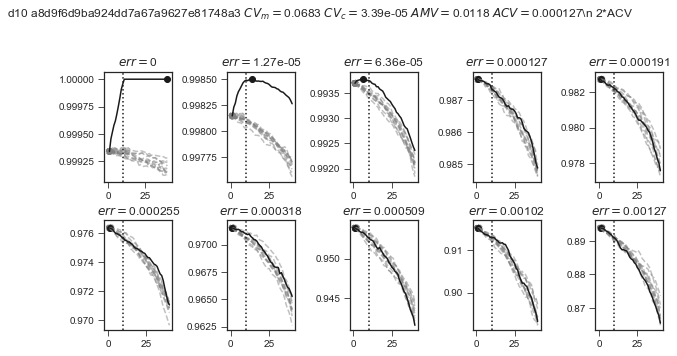

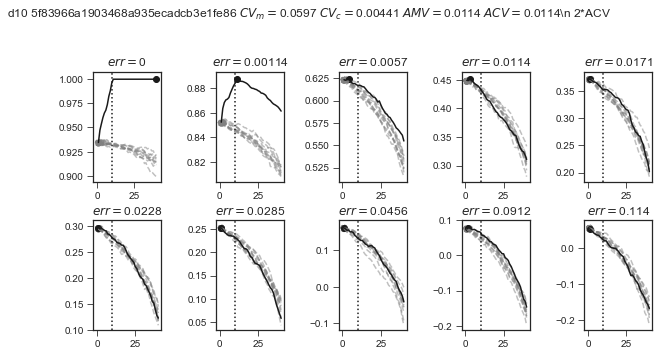

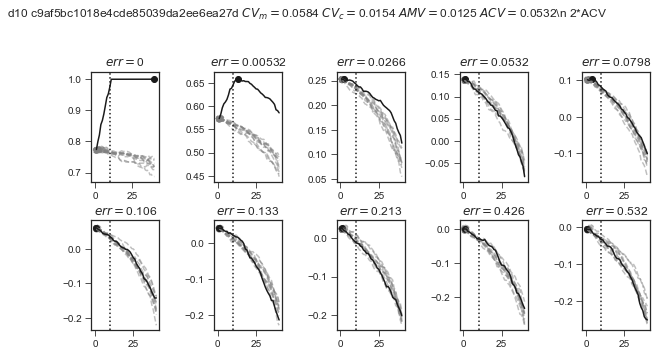

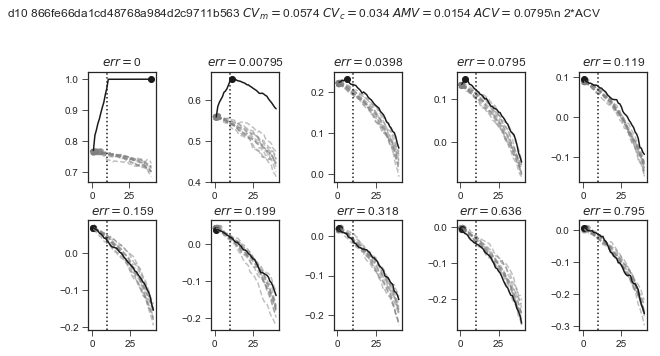

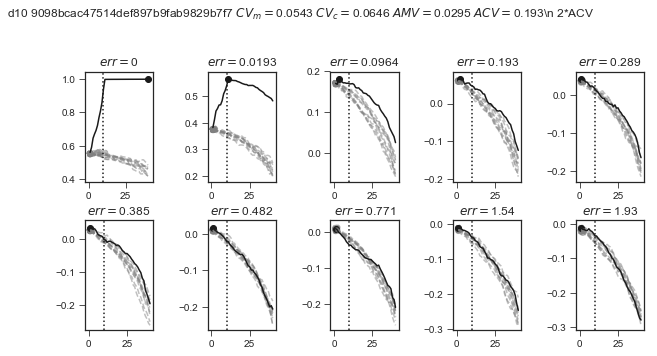

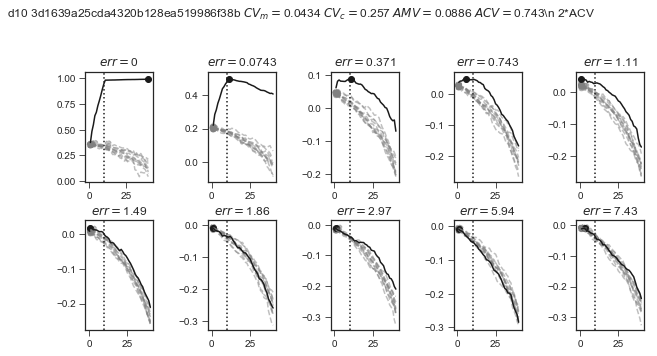

In [185]:
""" Default Predictions with multiple Cross Validation partitions """
# for sim in these_sims

# np.random.seed(9)

err_list = [1e-4,5e-4,1e-3]
err_list = [0]+[i*0.5e-4 for  i in range(2,11)]
err_list = [0]+[i*1e-3 for  i in range(2,11)]
err_list = [0]+[1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1.0]

n_folds = 5
n_cvs = 1
n_permutations = 10
d_true = 10


color_mapping = {1:0,2:1,3:2,4:3,5:4,10:5,20:6}
sim_ids = ['a8d9f6d9ba924dd7a67a9627e81748a3', # od = 0.01, max err < 0.0001
'5f83966a1903468a935ecadcb3e1fe86', # od = 0.1, max err: 0.001 - 0.005           
'c9af5bc1018e4cde85039da2ee6ea27d',# od = 0.2, max err: 0.01 - 0.05
'866fe66da1cd48768a984d2c9711b563', # od = 0.25, max err: 0.01 - 0.05
'9098bcac47514def897b9fab9829b7f7', # od = 0.5, max err: 0.05 - 0.1
'3d1639a25cda4320b128ea519986f38b'  # od = 1.0, max err: 0.5 - 1.0     
          ] 

optimum_deviation_dict = {'a8d9f6d9ba924dd7a67a9627e81748a3':0.01, # od = 0.01, max err < 0.0001
'5f83966a1903468a935ecadcb3e1fe86':0.1, # od = 0.1, max err: 0.001 - 0.005           
'c9af5bc1018e4cde85039da2ee6ea27d':0.2,# od = 0.2, max err: 0.01 - 0.05
'866fe66da1cd48768a984d2c9711b563':0.25, # od = 0.25, max err: 0.01 - 0.05
'9098bcac47514def897b9fab9829b7f7':0.5, # od = 0.5, max err: 0.05 - 0.1
'3d1639a25cda4320b128ea519986f38b':1.0  # od = 1.0, max err: 0.5 - 1.0      
}


# sim_id = sigma_sims['simulation_identifier'].values[0]
# d_true = sigma_sims['n_dimensions'].values[0]
for sim_id in sim_ids:
    f = p.read_csv('FitnessFiles/{}_gaussianfitness.csv'.format(sim_id))
    f = f[[col for col in f.columns if 'fitness' in col]]
    f = f.values
    avg_mutant_var = (np.mean(np.nanvar(f,axis=0)))
    avg_condition_var = (np.mean(np.nanvar(f,axis=1)/np.nanmean(f,axis=1)))
    condition_cv = (np.var(np.mean(f,axis=0))/np.mean(f))
    mutant_cv = (np.var(np.mean(f,axis=1))/np.mean(f))
    

    err_list = [0] + [i*avg_condition_var for i in [0.1,0.5,1.0,1.5,2.0,2.5,4.0,8.0,10]]
    optimum_deviation = optimum_deviation_dict[sim_id]

    # d_true = 10
    # optimum_deviation = 1.0
    # fitness, sim_id, n_dim, n_mut, n_con = simulation(d_true,250,50,optimum_deviation=optimum_deviation,dry_run=False)
    # f = fitness

    d_est = []
    d_list = []
    for cv in range(n_cvs):
        fig = plt.figure(figsize=(10,5))
        plt.suptitle(r'd{0} {1} $CV_m=${2:.3g} $CV_c=${3:.3g} $AMV=${4:.3g} $ACV=${5:.3g}\n 2*ACV'.format(d_true,sim_id,mutant_cv,condition_cv,avg_mutant_var,avg_condition_var))
        counter = 1

        n_mutants = f.shape[0]
        n_conditions = f.shape[1]
        max_rank = int((n_folds-1)*n_conditions/n_folds)
        mutant_permutation = np.random.permutation(n_mutants)
        new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
        condition_permtutation = np.random.permutation(n_conditions)
        new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


        folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

        for err in err_list:
            ax = plt.subplot(2,5,counter)
            counter += 1
            plt.title(r'$err=${0:.3g}'.format(err))
            this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
            true_var_explained = var_explained(this_set,f)[0]

            real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
            real_fits = real_fits/n_folds
    #         true_fits = true_fits/n_folds

            for perm in range(n_permutations):
                permuted_mutants = copy.copy(this_set)
    #             for row in range(this_set.shape[0]):
    #                 permuted_mutants[row] = np.random.permutation(this_set[row])

                perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
                perm_fits = perm_fits/n_folds


                plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
                plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
    #         true_fits = true_fits-(true_fits[0]-these_fits[0])

            plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
            plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

    #         plt.plot(range(1,max_rank+1),true_fits,color='r',label=d_true,alpha=1.0)
    #         plt.scatter(range(1,max_rank+1)[np.where(true_fits==np.max(true_fits))[0][0]],np.max(true_fits),color='r',alpha=1.0)

    #         plt.xlabel('D estimated')
    #         plt.ylabel('Variance Explained in Test Set')
            plt.axvline(x=d_true,color='k',linestyle=':')
    #         plt.axhline(y=true_var_explained,color='b',linestyle=':')


    #         true_var_explained.append(real_fits/n_folds)


    #     ax.
        fig.tight_layout()
        plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
        plt.savefig('SVDAnalysis/d{}_{}_{}_permTrain_error_ACV_normed_measures_range.pdf'.format(d_true,optimum_deviation,sim_id),bbox_inches='tight')





/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars


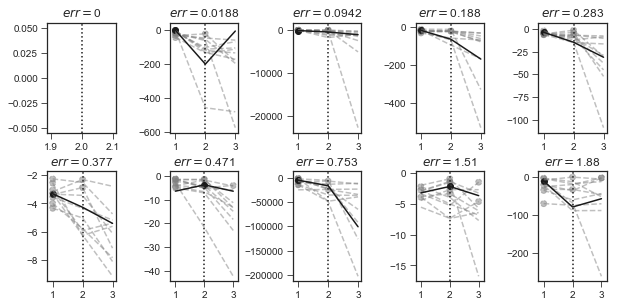

In [93]:
a = 0.5
b = 0.0
c = -0.25
x = 1.0
z = -0.1

f = np.asarray([[a,b,c,b],
                [b,a,b,c],
                [c,b,a,b],
                [b,c,b,a],
                [x,x,z,z],
                [z,x,x,z],
                [z,z,x,x],
                [x,z,z,x]
               ])

avg_mutant_var = (np.mean(np.nanvar(f,axis=0)))
avg_condition_var = (np.mean(np.nanvar(f,axis=1)))

n_mutants = 4
n_conditions = 4
n_folds = 4
d_true = 2

err_list = err_list = [0] + [i*avg_condition_var for i in [0.1,0.5,1.0,1.5,2.0,2.5,4.0,8.0,10]]
# optimum_deviation = optimum_deviation_dict[sim_id]

# d_true = 10
# optimum_deviation = 1.0
# fitness, sim_id, n_dim, n_mut, n_con = simulation(d_true,250,50,optimum_deviation=optimum_deviation,dry_run=False)
# f = fitness

d_est = []
d_list = []
for cv in range(n_cvs):
    fig = plt.figure(figsize=(10,5))
#     plt.suptitle(r'd{0} {1} $CV_m=${2:.3g} $CV_c=${3:.3g} $AMV=${4:.3g} $ACV=${5:.3g}'.format(d_true,sim_id,mutant_cv,condition_cv,avg_mutant_var,avg_condition_var))
    counter = 1

    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

    for err in err_list:
        ax = plt.subplot(2,5,counter)
        counter += 1
        plt.title(r'$err=${0:.3g}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds)
        real_fits = real_fits/n_folds
#         true_fits = true_fits/n_folds

        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)
#             for row in range(this_set.shape[0]):
#                 permuted_mutants[row] = np.random.permutation(this_set[row])

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')
#         true_fits = true_fits-(true_fits[0]-these_fits[0])

        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

#         plt.plot(range(1,max_rank+1),true_fits,color='r',label=d_true,alpha=1.0)
#         plt.scatter(range(1,max_rank+1)[np.where(true_fits==np.max(true_fits))[0][0]],np.max(true_fits),color='r',alpha=1.0)

#         plt.xlabel('D estimated')
#         plt.ylabel('Variance Explained in Test Set')
        plt.axvline(x=d_true,color='k',linestyle=':')
#         plt.axhline(y=true_var_explained,color='b',linestyle=':')


#         true_var_explained.append(real_fits/n_folds)


#     ax.
    fig.tight_layout()
    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

In [91]:
avg_mutant_var

0.07027343750000001

In [92]:
avg_condition_var

0.068359375

In [90]:
folds

[([4, 5], [3]), ([2, 7], [0]), ([0, 3], [2]), ([1, 6], [1])]

In [69]:
new_mutants

[[2], [3], [0], [1]]

In [66]:
new_conditions

[[1, 3], [0, 2]]

In [356]:
ACV = []
AMV = []
o_ds = [0.1,0.2,0.5]
m_ds = [0.1,0.2,0.5]
# n_folds = 5

for o_dispersal in o_ds:
    for m_dispersal in m_ds:

#         condition_points = []
#         for c in range(50):
#             condition_points.append(list(nball_pull(2,0.1,[o_dispersal,1.0],fixed_radius=True)))
#         mutant_points = []
#         for m in range(250):
#             mutant_points.append(list(nball_pull(2,1.0,[m_dispersal,1.0],fixed_radius=True)))
#         Ancestor = np.asarray([2.0,0.0])
#         Mutants = np.asarray(mutant_points)
#         Conditions = np.asarray(condition_points)
        condition_points = []
        for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
            condition_points.append(list(nball_pull(d_true,o_dispersal,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points = []
        for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
            mutant_points.append(list(nball_pull(d_true,m_dispersal,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
        Mutants = mutant_center + np.asarray(mutant_points)
#         print(Mutants)
        Conditions = np.asarray(condition_points)
        f = calculate_fitness(Mutants,Conditions,Ancestor)
        AMV.append((np.mean(np.nanvar(f,axis=0))))
        ACV.append((np.mean(np.nanvar(f,axis=1))))


Text(31.5,0.5,'o_dispersal')

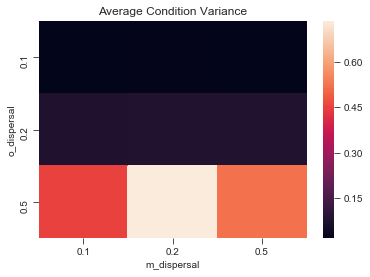

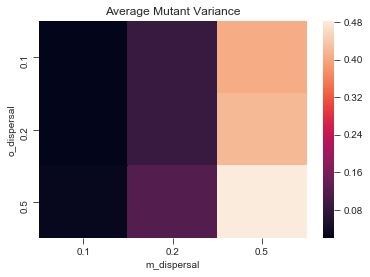

In [357]:
plt.title('Average Condition Variance')
sns.heatmap(np.asarray(ACV).reshape(len(o_ds),len(m_ds)))
plt.xticks(np.arange(len(m_ds))+0.5,m_ds)
plt.yticks(np.arange(len(o_ds))+0.5,o_ds)
plt.xlabel('m_dispersal')
plt.ylabel('o_dispersal')
plt.figure()
plt.title('Average Mutant Variance')
sns.heatmap(np.asarray(AMV).reshape(len(o_ds),len(m_ds)))
plt.xticks(np.arange(len(m_ds))+0.5,m_ds)
plt.yticks(np.arange(len(o_ds))+0.5,o_ds)
plt.xlabel('m_dispersal')
plt.ylabel('o_dispersal')

In [15]:
ACV = []
AMV = []
o_ds = [0.1,0.2,0.5]
m_ds = [0.1,0.2,0.5]
n_conditions = 50
n_mutants = 250
d_true = 10 
n_cvs = 1
n_folds = 5
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))

for o_dispersal in o_ds:
    for m_dispersal in m_ds:

        condition_points = []
        for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
            condition_points.append(list(nball_pull(d_true,o_dispersal,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points = []
        for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
            mutant_points.append(list(nball_pull(d_true,m_dispersal,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
        Mutants = mutant_center + np.asarray(mutant_points)
#         print(Mutants)
        Conditions = np.asarray(condition_points)
        f = calculate_fitness(Mutants,Conditions,Ancestor)
#         print(o_dispersal,m_dispersal)
        avg_mutant_var = (np.mean(np.nanvar(f,axis=0)))
        avg_condition_var = (np.mean(np.nanvar(f,axis=1)))
        condition_cv = (np.var(np.mean(f,axis=0))/np.mean(f))
        mutant_cv = (np.var(np.mean(f,axis=1))/np.mean(f))
#         real_fits,true_fits = SVD_predictions(f,f,folds,n_mutants,n_conditions,n_folds)
#         real_fits = real_fits/n_folds
        
#         non_mean_var_explain = (1-real_fits[0])/(d_true-1)
#         last_var_explain = (1-real_fits[d_true-1])


#         err_list = [0] + [i*avg_condition_var for i in [0.1,0.5,1.0,1.5,2.0,2.5,4.0,8.0,10]]
#         err_list = [0] + [i*non_mean_var_explain for i in [0.25,0.5,0.8,0.9,1.0,1.1,1.2,2.0,4.0]]
#         optimum_deviation = optimum_deviation_dict[sim_id]

        # d_true = 10
        # optimum_deviation = 1.0
        # fitness, sim_id, n_dim, n_mut, n_con = simulation(d_true,250,50,optimum_deviation=optimum_deviation,dry_run=False)
        # f = fitness

        d_est = []
        d_list = []
        for cv in range(n_cvs):
            fig = plt.figure(figsize=(10,5))
            plt.suptitle(r'd{0} {1} $CV_m=${2:.3g} $CV_c=${3:.3g} $AMV=${4:.3g} $ACV=${5:.3g}\n 2*ACV'.format(d_true,sim_id,mutant_cv,condition_cv,avg_mutant_var,avg_condition_var))
            counter = 1

            n_mutants = f.shape[0]
            n_conditions = f.shape[1]
            max_rank = int((n_folds-1)*n_conditions/n_folds)
            mutant_permutation = np.random.permutation(n_mutants)
            new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            condition_permtutation = np.random.permutation(n_conditions)
            new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

            for err in err_list:
                ax = plt.subplot(2,5,counter)
                counter += 1
                plt.title(r'$err=${0:.3g}'.format(err))
                this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
                true_var_explained = var_explained(this_set,f)[0]

                real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=True)
                real_fits = real_fits/n_folds
        #         true_fits = true_fits/n_folds

                for perm in range(n_permutations):
                    permuted_mutants = copy.copy(this_set)

                    perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=True)
                    perm_fits = perm_fits/n_folds


                    plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
                    plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.min(perm_fits))[0][0]],np.min(perm_fits),color='gray',alpha=0.5,linestyle='--')

                plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
                plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.min(real_fits))[0][0]],np.min(real_fits),color='k',alpha=1.0)

                plt.axvline(x=d_true,color='k',linestyle=':')

            fig.tight_layout()
            plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
#             plt.savefig('SVDAnalysis/simple_model_d{}_o{}_m{}_VE.pdf'.format(d_true,o_dispersal,m_dispersal),bbox_inches='tight')




NameError: name 'err_list' is not defined

<Figure size 720x360 with 0 Axes>

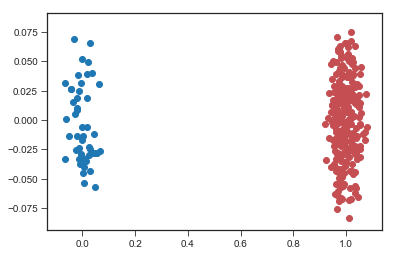

In [224]:
plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1])
plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r')

In [82]:
print(np.var([1,2,3]*1),np.var([1,2,3]*2),np.var([1,2,3]*10))

0.6666666666666666 0.6666666666666666 0.6666666666666666


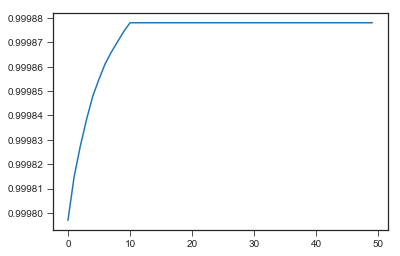

In [210]:
# SVD_predictions(f,f,folds,n_mutants,n_conditions,n_folds)
plt.plot(SVD_fits(f)[0])

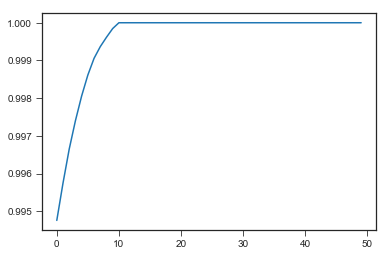

In [10]:
n_conditions = 50
n_mutants = 250
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = mutant_center + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
plt.plot(SVD_fits(f)[0])

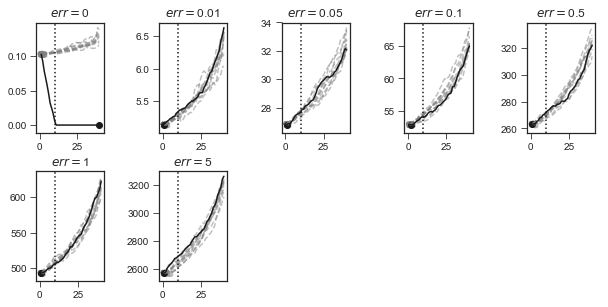

In [11]:
n_mutants = f.shape[0]
n_conditions = f.shape[1]
n_folds = 5
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1
fig = plt.figure(figsize=(10,5))
err_list = [0,0.01,0.05,0.1,0.5,1.0,5.0]
for err in err_list:
    for trial in range(n_trials):
        ax = plt.subplot(2,5,counter)

        plt.title(r'$err=${0:.3g}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=True)
        real_fits = real_fits/n_folds
    #         true_fits = true_fits/n_folds

        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=True)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.min(perm_fits))[0][0]],np.min(perm_fits),color='gray',alpha=0.5,linestyle='--')

        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.min(real_fits))[0][0]],np.min(real_fits),color='k',alpha=1.0)

        plt.axvline(x=d_true,color='k',linestyle=':')
    counter += 1
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

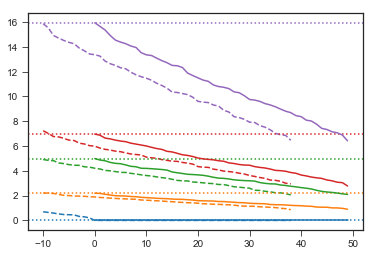

In [19]:
###### plt.plot(SVD_fits(f)[0],label=0)
end = 5
max_d = 10
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    plt.plot(np.arange(-10,len(s)-1-10),s[1:],'--')
#     plt.plot(np.arange(-10,len(s)-1-10),s[1:],'--')
plt.gca().set_prop_cycle(None)
# plt.figure()
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    line, = plt.plot(s[:])
#     plt.gca()._get_lines.prop_cycler.prev()
    plt.axhline(s[0],linestyle=':',color = line.get_color())
# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     plt.axhline(sv,linestyle=":",color='k')

# plt.xlim(-11,1)

In [399]:
np.sqrt(2)*np.asarray(err_list)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))

[0, 0.01, 0.05, 0.1, 0.5, 1.0]

In [409]:
np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))

array([ 0.        ,  2.28824561,  5.11667274,  7.23606798, 16.18033989,
       22.88245611])

In [51]:
err_list = [0,0.0001,0.001,0.0025,0.005,0.0075,0.01]

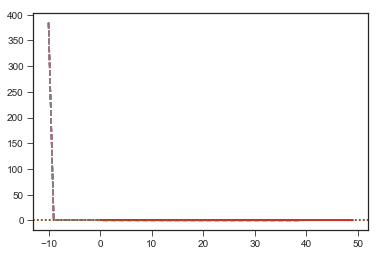

In [52]:
###### plt.plot(SVD_fits(f)[0],label=0)
end = 4
max_d = 10
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    plt.plot(np.arange(-10,len(s)-10),s[:],'--')
    plt.plot(np.arange(-10,len(s)-10),s[:],'--')
plt.gca().set_prop_cycle(None)
# plt.figure()
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    line, = plt.plot(s[:])
#     plt.gca()._get_lines.prop_cycler.prev()
    plt.axhline(s[0],linestyle=':',color = line.get_color())
# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     plt.axhline(sv,linestyle=":",color='k')

# plt.xlim(-11,1)

(0, 20)

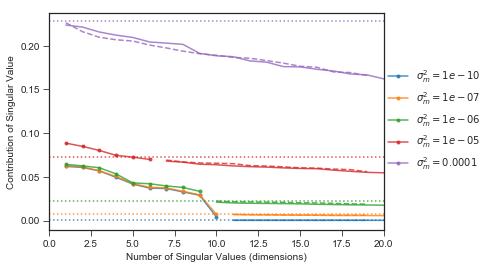

In [16]:
###### plt.plot(SVD_fits(f)[0],label=0)
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])


end = 6
max_d = 20
true_d = 10-1
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    
    line, = plt.plot(np.arange(1,max_detectable),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable,len(s)),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable,max_d),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)

# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     
# plt.savefig('SVDAnalysis/sv_contribution_d10.pdf',bbox_inches='tight')
# plt.xlim(-11,1)

In [23]:
###### plt.plot(SVD_fits(f)[0],label=0)
end = 6
max_d = 50
true_d = 10-1
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()
    

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    
    line, = plt.plot(np.arange(1,max_detectable),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable,len(s)),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable,max_d),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')

# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     
# plt.savefig('SVDAnalysis/sv_contribution_d10.pdf',bbox_inches='tight')
# plt.xlim(-11,1)

AttributeError: 'int' object has no attribute 'flatten'

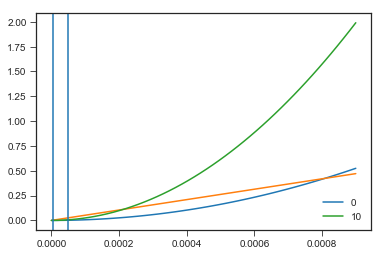

In [52]:
sigmas = np.linspace(1e-7,9e-4)
# np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
plt.plot(sigmas,[(n_conditions*sigma/s_list[0][1])**2 for sigma in sigmas],label='0')
plt.plot(sigmas,[(np.sqrt(2)*np.sqrt(sigma)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)))**2 for sigma in sigmas])
plt.plot(sigmas,[(n_conditions*sigma/s_list[0][9])**2 for sigma in sigmas],label='10')
plt.axvline(5e-6)
plt.axvline(5e-5)
plt.legend()

In [25]:
s_list[0]

array([6.12291302e+00, 6.21167362e-02, 5.31026978e-02, 5.04223926e-02,
       4.98811412e-02, 4.47633734e-02, 4.14939259e-02, 3.68899297e-02,
       3.49024939e-02, 3.18923386e-02, 3.99664385e-03, 2.15172473e-04,
       2.07483380e-04, 2.00158484e-04, 1.96501665e-04, 1.92698564e-04,
       1.91882943e-04, 1.87571542e-04, 1.84559725e-04, 1.80189701e-04,
       1.77131728e-04, 1.75940804e-04, 1.74171432e-04, 1.69161600e-04,
       1.67632943e-04, 1.64639271e-04, 1.61315970e-04, 1.60838854e-04,
       1.56708540e-04, 1.55204305e-04, 1.53685257e-04, 1.50130394e-04,
       1.46791460e-04, 1.45905266e-04, 1.44140634e-04, 1.41770275e-04,
       1.41266208e-04, 1.37137585e-04, 1.30082253e-04, 1.28107821e-04,
       1.26908760e-04, 1.24535215e-04, 1.21502657e-04, 1.19876752e-04,
       1.15902670e-04, 1.13708992e-04, 1.07611154e-04, 1.03393595e-04,
       1.02375101e-04, 9.98927061e-05])

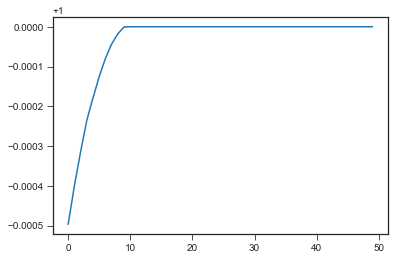

In [20]:
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
plt.plot(SVD_fits(f)[0])

2.2882456112707375e-09 0.264887008917972
2.2882456112707375e-06 0.264887008917972
2.2882456112707376e-05 0.264887008917972
0.00022882456112707376 0.264887008917972
0.002288245611270737 0.264887008917972


Text(0,0.5,'Contribution of Singular Value')

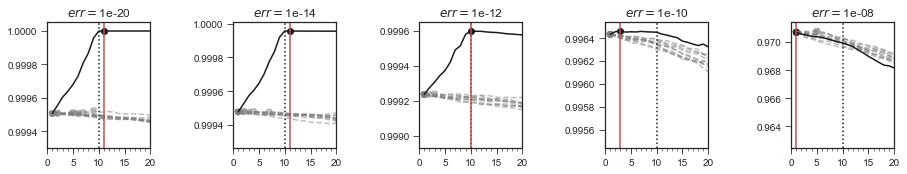

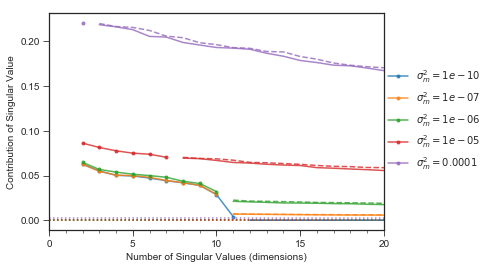

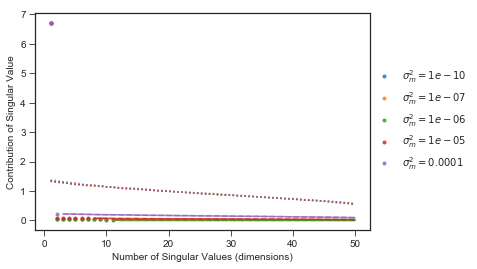

In [11]:
# n_mutants = 250
# n_conditions = 50
# d_true = 10
# mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
# condition_points = []
# for c in range(n_conditions):
# #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
#     condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
# mutant_points = []
# for m in range(n_mutants):
# #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
#     mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
# Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
# Mutants = Ancestor + np.asarray(mutant_points)
# Conditions = np.asarray(condition_points)
# f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])

n_mutants = f.shape[0]
n_conditions = f.shape[1]
n_folds = 5
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

s_list = []
noise_list = []
perm_s_list = []
mean_error = []

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1
fig = plt.figure(figsize=(15,5))
# err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
err_list = [1e-10,1e-7,1e-6,1e-5,1e-4]
for err in err_list:
    for trial in range(n_trials):
        ax = plt.subplot(2,5,counter)
        
        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
        # non-uniform error 
#         errors = np.random.uniform(err-err/2,err+err/2,len(f.flatten()))
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[i])) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
        # each mutant has error
#         err = np.sqrt(err)
#         errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[0])
#         errors = errors**2
# #         errors = np.random.uniform(err-19*err/20,err+3*err/4,f.shape[0]) 
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[i]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])

        # each condition has error
#         errors = np.random.uniform(err-99*err/100,err+99*err/100,,f.shape[1])
#         err = np.sqrt(err)
#         errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[1])
#         errors = errors**2
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[j]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])


        # multivariate
#         epsilons = np.asarray(np.random.multivariate_normal(np.zeros(len(f.flatten()))))

        err = err**2
#         errors = errors**2
        mean_error.append(err)
        print(np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)),np.sqrt(2)*np.sqrt(np.mean(errors))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)))
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])


        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)
        
        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)
        
        plt.title(r'$err=${0:.3g}'.format(err))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds
    #         true_fits = true_fits/n_folds

        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=False)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')

        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

        plt.axvline(x=d_true,color='k',linestyle=':')
        plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],color='r',linestyle='-')
        plt.xlim(0,20)
        plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
        plt.gca().set_xticks(range(20),True)
#         plt.gca().set_xticks(np.arange(0,25,5),False)
#         plt.xticks(np.arange(20,5))
    counter += 1
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
end = len(err_list)
max_d = 50
true_d = 10
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    

    if np.any((s < noise_s[0])):
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
#     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
#     err = mean_error[e]
    sv = np.sqrt(2)*err*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(20),True)

plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
end = len(err_list)
max_d = 50
true_d = 10
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    
    if np.any((s < noise_s[0])):
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(1,max_detectable+1),s[:max_detectable],marker='.',linestyle='',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))

    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)


    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
#     sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
#     plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')

# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     
# plt.savefig('SVDAnalysis/sv_contribution_d10.pdf',bbox_inches='tight')
# plt.xlim(-11,1)

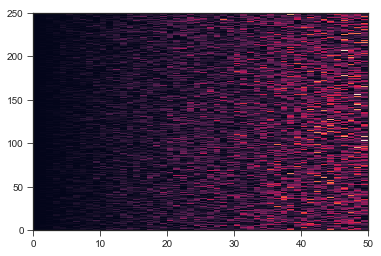

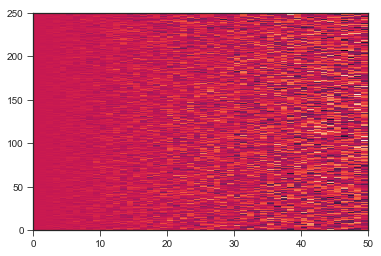

In [33]:
plt.pcolormesh(np.abs(epsilons))
plt.figure()
plt.pcolormesh(epsilons)

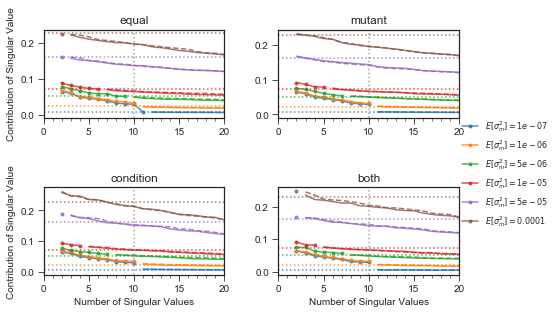

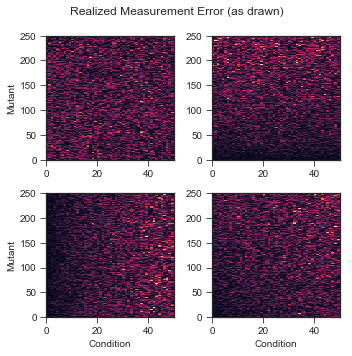

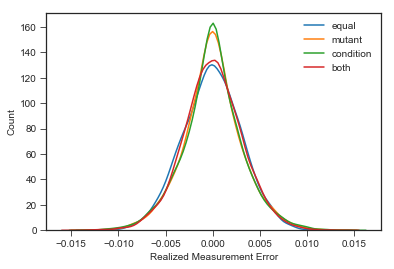

In [112]:
n_mutants = 250
n_conditions = 50
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])

n_mutants = f.shape[0]
n_conditions = f.shape[1]
n_folds = 5
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1
fig = plt.figure(figsize=(9,5))

err_list = [1e-7,1e-6,5e-6,1e-5,5e-5,1e-4]
epsilon_sets = []

error_sets = ['equal','mutant','condition','both']
for e_set in range(len(error_sets)):
    error_set = error_sets[e_set]
    s_list = []
    noise_list = []
    perm_s_list = []
    mean_error = []
    for err in err_list:
        
        if error_set == 'equal':
            epsilons = np.asarray([np.random.normal(0,np.sqrt(err))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            mean_error.append(err)
            epsilon_sets.append(epsilons)
            
        if error_set == 'mutant':
#             err = np.sqrt(err)
            errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[0])
#             errors = errors**2
            epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[i]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            mean_error.append(np.mean(errors))
            epsilon_sets.append(epsilons)

        if error_set == 'condition':
            
#             err = np.sqrt(err)
            errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[1])
#             errors = errors**2
            epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[j]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            mean_error.append(np.mean(errors))
            epsilon_sets.append(epsilons)

        if error_set == 'both':
            
#             err = np.sqrt(err)
            condition_errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[1])
#             condition_errors = condition_errors**2
            mutant_errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[0])
#             mutant_errors = mutant_errors**2
            epsilons = np.asarray([np.random.normal(0,np.sqrt(condition_errors[j]/2+mutant_errors[i]/2))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            errors = np.zeros((f.shape[0],f.shape[1]))
            for i in range(f.shape[0]):
                for j in range(f.shape[1]):
                    errors[i][j] = condition_errors[j]/2+mutant_errors[i]/2
            mean_error.append(np.mean(errors))
            epsilon_sets.append(epsilons)

        err = err**2

        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

#         U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
#         perm_s_list.append(perm_s)

#         plt.title(r'$err=${0:.3g}'.format(err))
#         true_var_explained = var_explained(this_set,f)[0]

#         real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
#         real_fits = real_fits/n_folds
#     #         true_fits = true_fits/n_folds

#         for perm in range(n_permutations):
#             permuted_mutants = copy.copy(this_set)

#             perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=False)
#             perm_fits = perm_fits/n_folds


#             plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
#             plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')

#         plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
#         plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

#         plt.axvline(x=d_true,color='k',linestyle=':')
#         plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],color='r',linestyle='-')
#         plt.xlim(0,20)
#         plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#         plt.gca().set_xticks(range(20),True)
#     #         plt.gca().set_xticks(np.arange(0,25,5),False)
#     #         plt.xticks(np.arange(20,5))
#         counter += 1
#     fig.tight_layout()
#     plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

    plt.subplot(2,2,e_set+1)
    ###### plt.plot(SVD_fits(f)[0],label=0)
    end = len(err_list)
    max_d = 50
    true_d = 10
    plt.axvline(true_d,linestyle=':',color ='k',alpha=0.4)
    for e in range(len(err_list[:end])):
        err = err_list[e]

        s = s_list[e]
        noise_s = noise_list[e]
#         perm_s = perm_s_list[e]


        if np.any((s < noise_s[0])):
            max_detectable = np.where(s < noise_s[0])[0][0]
        else:
            max_detectable = max_d

        line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$E[\sigma_m^2] ={}$'.format(err))
        plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
        plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    #     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)

        # empirical max
    #     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)

        # expected theoretical max
        err = mean_error[e]
        sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
        plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
        
    plt.title(error_set)
    if e_set in [0,2]:
        plt.ylabel('Contribution of Singular Value')
    if e_set in [2,3]:
        plt.xlabel('Number of Singular Values')
    
    plt.xlim(0,20)
    plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
    plt.gca().set_xticks(range(20),True)
plt.legend(loc=(1.0,0.5),fontsize=8)
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.3, top=0.8)
plt.savefig('SVDAnalysis/uneven_error.pdf',bbox_inches='tight')

offset = 3
eps_figure = plt.figure(figsize=(5,5))
for e_set in range(len(error_sets)):
    plt.subplot(2,2,e_set+1)
    plt.pcolormesh(np.abs(epsilon_sets[len(err_list)*e_set+offset]),
                   vmin=np.min(np.abs(np.asarray([epsilon_sets[len(err_list)*e_set+offset] for e in range(len(error_sets))]))), 
                    vmax=np.max(np.abs(np.asarray([epsilon_sets[len(err_list)*e_set+offset] for e in range(len(error_sets))]))))
    if e_set in [0,2]:
        plt.ylabel('Mutant')
    if e_set in [2,3]:
        plt.xlabel('Condition')
#     plt.pcolormesh(epsilon_sets[len(err_list)*e_set+offset])
plt.suptitle('Realized Measurement Error (as drawn)')
eps_figure.tight_layout()

plt.subplots_adjust(wspace=0.3, top=0.9)
plt.savefig('SVDAnalysis/uneven_error_heatmaps.pdf',bbox_inches='tight')

# eps_figure = plt.figure(figsize=(9,5))
plt.figure()
for e_set in range(len(error_sets)):
    sns.distplot(epsilon_sets[len(err_list)*e_set+offset].flatten(),hist=False,label=error_sets[e_set])
plt.legend()
plt.xlabel('Realized Measurement Error')
plt.ylabel('Count')
plt.savefig('SVDAnalysis/uneven_error_kdes.pdf',bbox_inches='tight')


In [18]:
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])

In [ ]:
plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]
end = len(err_list)
max_d = 50
true_d = 2
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]**2/(np.sum(s_list[e]**2))
    noise_s = noise_list[e]**2/(np.sum(s_list[e]**2))
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(20),True)

IndexError: list index out of range

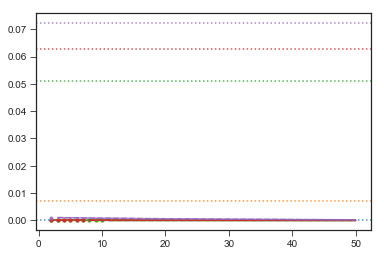

In [19]:
plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]
end = len(err_list)
max_d = 50
true_d = 2
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]**2/(np.sum(s_list[e]**2))
    noise_s = noise_list[e]**2/(np.sum(s_list[e]**2))
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(20),True)

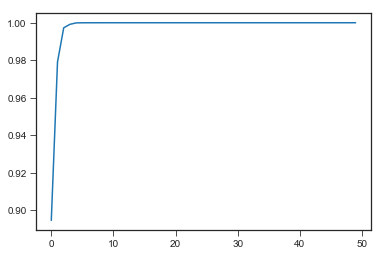

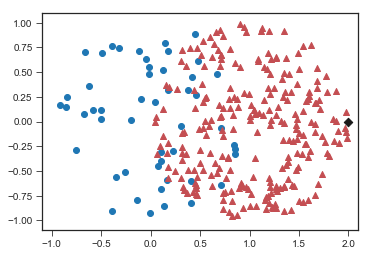

In [78]:
n_mutants = 250
n_conditions = 50



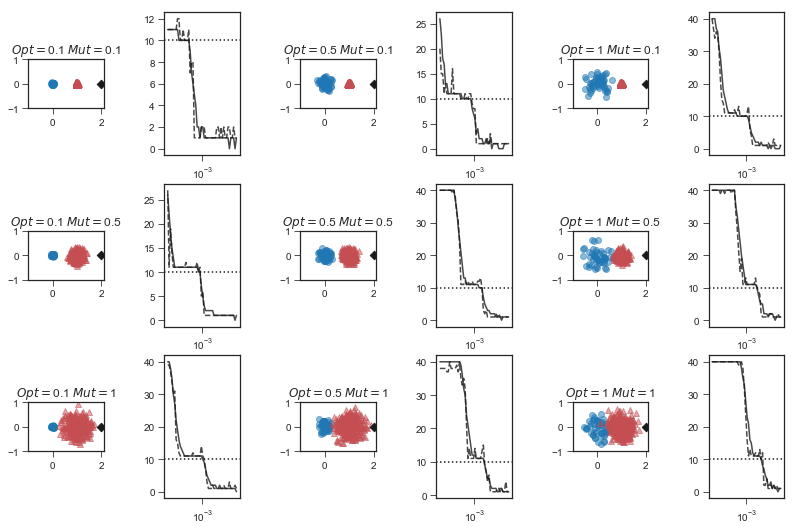

In [113]:
d_true = 10
sims = [(0.1,0.1),(0.5,0.1),(1.0,0.1),(0.1,0.5),(0.5,0.5),(1.0,0.5),(0.1,1.0),(0.5,1.0),(1.0,1.0)]
plt.figure(figsize=(15,10))
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]
    
    
    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
    
    condition_points = []
    for c in range(n_conditions):
    #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
#     plt.plot(SVD_fits(f)[0])
    
    ax = plt.subplot(3,6,2*sim+1)
    plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1],alpha=0.5)
    plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r',marker='^',alpha=0.5)
    plt.scatter(Ancestor[0],Ancestor[1],color='k',marker='D')
#     plt.xlim(0-opt_spread-0.1,1+mut_spread+0.1)
#     plt.ylim(0-opt_spread-0.1,0+max(opt_spread,mut_spread)+0.1)
    plt.xlim(-1,2.1)
    plt.ylim(-1,1)

    plt.gca().set_aspect('equal')



    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    n_folds = 5
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    n_permutations = 10
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]



    n_trials = 1

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
    d_list = []
    max_detect_list = []
    # fig = plt.figure(figsize=(15,5))
    # err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
    # err_list = [1e-8,5e-5,1e-7,,1e-6,1e-5,1e-4,1e-2,1e-1,1.0,10.0]
    err_list = [1e-8*10**n for n in range(9)]
    five_err_list = [5*x for x in err_list]
    err_list = list(chain.from_iterable(zip(err_list, five_err_list)))
    err_list = np.logspace(-8,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)

        plt.title(r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds

        d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)
    ax = plt.subplot(3,6,2*sim+2)
    plt.plot(err_list,d_list,color='k',linestyle='--',alpha=0.8,label='Cross Validation')
    plt.plot(err_list,max_detect_list,color='k',alpha=0.8,label='SVD Contribution')
    plt.axhline(y=d_true,color='k',linestyle=':')
    plt.xscale('log')
# plt.legend()
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.savefig('SVDAnalysis/detectability_by_spreads_explicit.pdf',bbox_inches='tight')

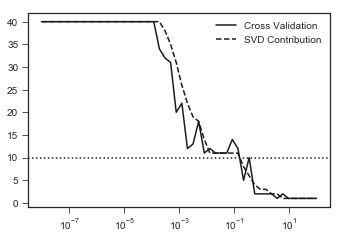

In [101]:
plt.figure()
plt.plot(err_list,d_list,color='k',label='Cross Validation')
plt.plot(err_list,max_detect_list,color='k',linestyle='--',label='SVD Contribution')
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend()
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

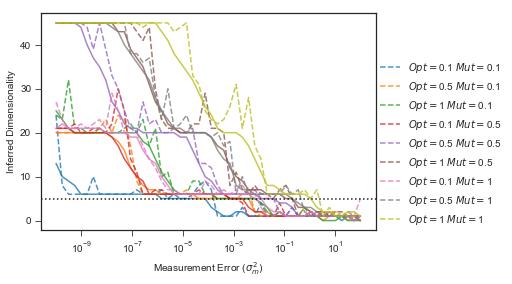

In [114]:
d_true = 5

n_mutants = 250
n_conditions = 50
n_folds = 10
sims = [(0.1,0.1),(0.5,0.1),(1.0,0.1),(0.1,0.5),(0.5,0.5),(1.0,0.5),(0.1,1.0),(0.5,1.0),(1.0,1.0)]
plt.figure()
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]
    
    
    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
    
    condition_points = []
    for c in range(n_conditions):
    #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
#     plt.plot(SVD_fits(f)[0])
    
#     ax = plt.subplot(3,6,2*sim+1)
#     plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1],alpha=0.5)
#     plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r',marker='^',alpha=0.5)
#     plt.scatter(Ancestor[0],Ancestor[1],color='k',marker='D')
# #     plt.xlim(0-opt_spread-0.1,1+mut_spread+0.1)
# #     plt.ylim(0-opt_spread-0.1,0+max(opt_spread,mut_spread)+0.1)
#     plt.xlim(-1,2.1)
#     plt.ylim(-1,1)

#     plt.gca().set_aspect('equal')



    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    n_permutations = 10
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]



    n_trials = 1

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
    d_list = []
    max_detect_list = []
    # fig = plt.figure(figsize=(15,5))
    # err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
    # err_list = [1e-8,5e-5,1e-7,,1e-6,1e-5,1e-4,1e-2,1e-1,1.0,10.0]
#     err_list = [1e-8*10**n for n in range(9)]
#     five_err_list = [5*x for x in err_list]
#     err_list = list(chain.from_iterable(zip(err_list, five_err_list)))
    err_list = np.logspace(-10,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)

#         plt.title(r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds

        d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)
#     ax = plt.subplot(3,6,2*sim+2)
    line, = plt.plot(err_list,d_list,linestyle='--',alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
    plt.plot(err_list,max_detect_list,color=line.get_color(),alpha=0.8)
#     plt.plot(err_list,max_detect_list,alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/detectability_by_spreads_both_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justCV_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justsvd_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

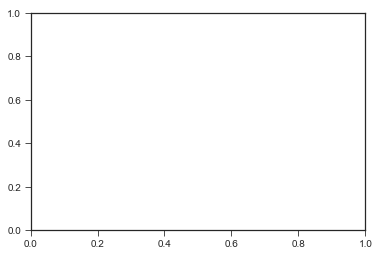

In [120]:
d_true = 10

n_mutants = 250
n_conditions = 50
fold_list = [2,5,10,25,50]
sims = [(0.5,0.5)]
plt.figure()
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]


    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))

    condition_points = []
    for c in range(n_conditions):
        #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
    err_list = np.logspace(-10,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)
        
        for n_folds in fold_list:

            n_mutants = f.shape[0]
            n_conditions = f.shape[1]

            max_rank = int((n_folds-1)*n_conditions/n_folds)
            n_permutations = 10
            mutant_permutation = np.random.permutation(n_mutants)
            new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            condition_permtutation = np.random.permutation(n_conditions)
            new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
            d_list = []
            max_detect_list = []
            
            true_var_explained = var_explained(this_set,f)[0]

            real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
            real_fits = real_fits/n_folds

            d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
            if np.any((s < noise_s[0])):
                if np.where(s < noise_s[0])[0][0] < max_rank:
                    max_detect_list.append(np.where(s < noise_s[0])[0][0])
                else:
                    max_detect_list.append(max_rank)
            else:
                max_detect_list.append(max_rank)

        line, = plt.plot(err_list,d_list,,alpha=0.8,label=r'{} folds'.format(n_folds))
    #     plt.plot(err_list,max_detect_list,color=line.get_color(),alpha=0.8)
    #     plt.plot(err_list,max_detect_list,alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/detectability_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justsvd_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (50,) and (5,)

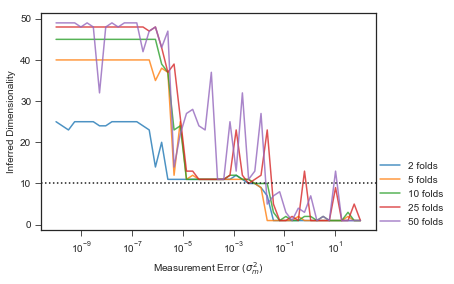

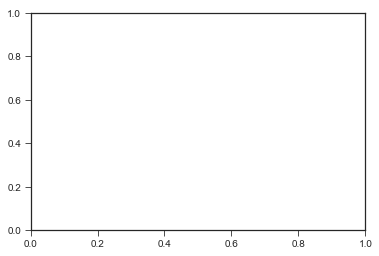

In [17]:
d_true = 10

n_mutants = 250
n_conditions = 50
fold_list = [2,5,10,25,50]
sims = [(0.5,0.5)]
plt.figure()
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]


    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))

    condition_points = []
    for c in range(n_conditions):
        #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
    err_list = np.logspace(-10,2)
    
    d_list = []
    fit_list = []
    for e in range(len(err_list)):
        err = err_list[e]
        d_list.append([])
        fit_list.append([])
        
        s_list = []
        noise_list = []
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)

#         U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
#         perm_s_list.append(perm_s)
        
        for n_folds in fold_list:

            n_mutants = f.shape[0]
            n_conditions = f.shape[1]

            max_rank = int((n_folds-1)*n_conditions/n_folds)
            n_permutations = 10
            mutant_permutation = np.random.permutation(n_mutants)
            new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            condition_permtutation = np.random.permutation(n_conditions)
            new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
#             d_list[e] = []
            max_detect_list = []
            
            true_var_explained = var_explained(this_set,f)[0]

            real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
            real_fits = real_fits/n_folds

            d_list[e].append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
            fit_list[e].append(np.max(real_fits))
    
    d_list = np.asarray(d_list).swapaxes(0,1)
    for f in range(len(fold_list)):
        
        line, = plt.plot(err_list,d_list[f],alpha=0.8,label=r'{} folds'.format(fold_list[f]))
    #     plt.plot(err_list,max_detect_list,color=line.get_color(),alpha=0.8)
    #     plt.plot(err_list,max_detect_list,alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/detectability_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')

fit_list = np.asarray(fit_list).swapaxes(0,1)
plt.figure()
for f in range(len(fold_list)):     
    line, = plt.plot(err_list,fit_list[f],alpha=0.8,label=r'{} folds'.format(fold_list[f]))

# plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/fit_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justsvd_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')

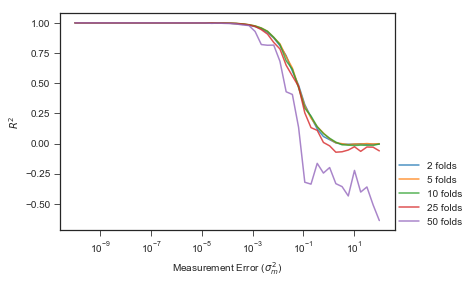

In [22]:
fit_list = np.asarray(fit_list).swapaxes(0,1)
plt.figure()
for f in range(len(fold_list)):     
    line, = plt.plot(err_list,fit_list[f],alpha=0.8,label=r'{} folds'.format(fold_list[f]))

# plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel(r'$R^2$')
plt.savefig('SVDAnalysis/fit_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')

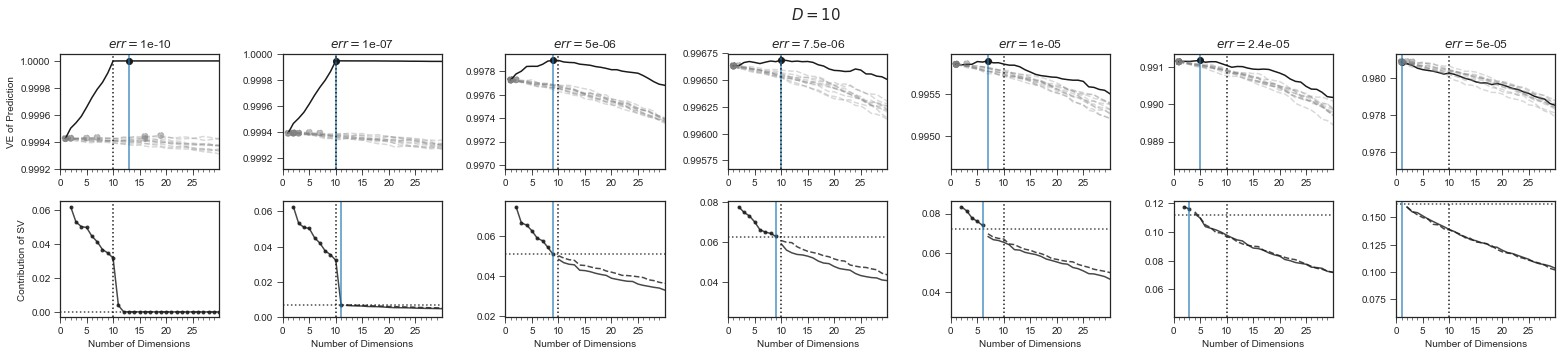

In [20]:
n_mutants = f.shape[0]
n_conditions = f.shape[1]
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

s_list = []
noise_list = []
perm_s_list = []

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1

err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]

fig = plt.figure(figsize=(3*len(err_list),5))


for err in err_list:
    for trial in range(n_trials):
        ax = plt.subplot(2,len(err_list),counter)
        if counter == 1:
            plt.ylabel('VE of Prediction')
        
        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)
        
        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)
        

        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds
        
        line, = plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color=line.get_color(),alpha=1.0)



        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=False)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,label=d_true,alpha=0.3,color='gray',linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')

        plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],linestyle='-',alpha=0.8)
        plt.axvline(x=d_true,color='k',linestyle=':')
        
#         plt.xlim(0,20)
#         plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#         plt.gca().set_xticks(range(20),True)
        plt.xlim(0,30)
        plt.xticks(np.arange(0,30,5),np.arange(0,30,5))
        plt.gca().set_xticks(range(30),True)
        plt.title(r'$err=${0:.3g}'.format(err))
#         plt.gca().set_xticks(np.arange(0,25,5),False)
#         plt.xticks(np.arange(20,5))
    counter += 1


# plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
end = len(err_list)
max_d = 50
true_d = 5
for e in range(len(err_list[:end])):
    ax = plt.subplot(2,len(err_list),counter)
    
    if e == 0:
        plt.ylabel('Contribution of SV')
    
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],color='k',marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
#     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    plt.axvline(x=max_detectable,linestyle='-',alpha=0.8)
    plt.axvline(x=d_true,color='k',linestyle=':')
    
    counter += 1
#     plt.xlim(0,20)
#     plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#     plt.gca().set_xticks(range(20),True)
    plt.xlim(0,30)
    plt.xticks(np.arange(0,30,5),np.arange(0,30,5))
    plt.gca().set_xticks(range(30),True)
    plt.xlabel('Number of Dimensions')
    
plt.suptitle(r'$D={}$'.format(d_true),fontsize=15)

fig.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.4, top=0.85)
# plt.savefig('SVDAnalysis/prediction_contrib_comparison_d{}.pdf'.format(d_true),bbox_inches='tight')

In [ ]:
d_true = 5
sims = [(0.1,0.1),(0.5,0.1),(1.0,0.1),(0.1,0.5),(0.5,0.5),(1.0,0.5),(0.1,1.0),(0.5,1.0),(1.0,1.0)]
for sim in range(len(sims)) 
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]
    
    
    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
    
    condition_points = []
    for c in range(n_conditions):
    #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
    plt.plot(SVD_fits(f)[0])
    plt.figure()
    plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1])
    plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r',marker='^')
    plt.scatter(Ancestor[0],Ancestor[1],color='k',marker='D')
    plt.xlim(0-opt_spread-0.1,1+mut_spread+0.1)
    plt.ylim(0-opt_spread-0.1,0+max(opt_spread,mut_spread)+0.1)

    plt.gca().set_aspect('equal')



    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    n_folds = 5
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    n_permutations = 10
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]



    n_trials = 1

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
    d_list = []
    max_detect_list = []
    # fig = plt.figure(figsize=(15,5))
    # err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
    # err_list = [1e-8,5e-5,1e-7,,1e-6,1e-5,1e-4,1e-2,1e-1,1.0,10.0]
    err_list = [1e-8*10**n for n in range(9)]
    five_err_list = [5*x for x in err_list]
    err_list = list(chain.from_iterable(zip(err_list, five_err_list)))
    err_list = np.logspace(-8,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)

        plt.title(r'$err=${0:.3g}'.format(err))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds

        d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)
    
    plt.plot(err_list,d_list,color='b',label='Cross Validation')
    plt.plot(err_list,max_detect_list,color='r',label='SVD Contribution')
    plt.axhline(y=d_true,color='k',linestyle=':')
    plt.xscale('log')
plt.legend()
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)